In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("heart.csv")

In [4]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
numeric_df = df.select_dtypes(np.number)
scaled_features = StandardScaler().fit_transform(numeric_df.values)
scaled_df = pd.DataFrame(scaled_features, columns=numeric_df.columns)

In [4]:
cat_df = df.select_dtypes(exclude=np.number)
dummy_df = pd.get_dummies(
    cat_df, drop_first=True
)  # Drop first dummy variable as a base

In [5]:
features = pd.concat([scaled_df, dummy_df], axis=1)
features["HeartDisease"] = df[
    "HeartDisease"
]  # Undo standard scaling for target variable

In [6]:
x = features.drop(columns=["HeartDisease"])
y = features["HeartDisease"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

## Discriminant Analysis (LDA/QDA)

In [9]:
# LDA
# Start with solver
grid = {'solver': ['svd', 'lsqr', 'eigen']}

lda_mod = LinearDiscriminantAnalysis()
clf = GridSearchCV(lda_mod, param_grid=grid, scoring='roc_auc', cv=10, n_jobs=-1)
best_lda = clf.fit(X_train, y_train)

# SVD is best solver, so no shrinkage tuning required
print(best_lda.best_estimator_.get_params())

{'n_components': None, 'priors': None, 'shrinkage': None, 'solver': 'svd', 'store_covariance': False, 'tol': 0.0001}


In [10]:
# roc_auc = .887, accuracy = .88
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       109
           1       0.93      0.87      0.90       167

    accuracy                           0.88       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.88      0.88       276

0.8866670329066637


In [11]:
# QDA

grid = {'reg_param': [0, 0.1, 0.2, 0.3, 0.4, 0.5]}

qda_mod = QuadraticDiscriminantAnalysis()
clf_qda = GridSearchCV(qda_mod, param_grid=grid, scoring='roc_auc', cv=10, n_jobs=-1)
best_qda = clf_qda.fit(X_train, y_train)

print(best_qda.best_estimator_.get_params())

{'priors': None, 'reg_param': 0.1, 'store_covariance': False, 'tol': 0.0001}


In [12]:
# roc_auc = .879, accuracy = .87
y_pred = clf_qda.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       109
           1       0.93      0.89      0.91       167

    accuracy                           0.89       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.89      0.89       276

0.8880679008954567


## SVM

In [13]:
# SVM
svm_mod = SVC(random_state=0)

grid = {
    'C': [.01, .1, 1, 10],
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'gamma': ['auto', 10, 1, .1, .01, .001]
}

# grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

clf_svm = GridSearchCV(svm_mod, param_grid=grid, scoring='roc_auc', cv=10, n_jobs=-1, verbose=2)
best_svm = clf_svm.fit(X_train, y_train)
print(best_svm.best_estimator_.get_params())

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   12.7s


{'C': 10, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.01, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 0, 'shrinking': True, 'tol': 0.001, 'verbose': False}


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   44.2s finished
/Users/sam/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
# roc_auc = .877, accuracy = .88
y_pred = clf_svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       109
           1       0.91      0.89      0.90       167

    accuracy                           0.88       276
   macro avg       0.87      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276

0.8773004449815964


## XGBoost

In [7]:
# XGBoost
xgb_mod = XGBClassifier(random_state=0)

dist = {
        'eta': [0.01, 0.05, 0.1, 0.2, 0.3],
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.1, 0.5, 1.0, 5, 10],
        'subsample': np.arange(0.5, 1, 0.1),
        'colsample_bytree': np.arange(0.5, 1, 0.1),
        'max_depth': np.arange(3, 10, 2),
        'scale_pos_weight': [1, 1.2],
        'reg_alpha': [0, 0.1, 1.0, 10.0, 100.0],
        'reg_lambda': [0, 0.1, 1.0, 10.0, 100.0]
        }

clf_xgb = RandomizedSearchCV(xgb_mod, param_distributions=dist, scoring='roc_auc', n_iter=100000, cv=10, random_state=1, n_jobs=-1, verbose=2)
best_xgb = clf_xgb.fit(X_train, y_train)
print(best_xgb.best_estimator_.get_params())

Fitting 10 folds for each of 100000 candidates, totalling 1000000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.8999999999999999, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 5, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'scale_pos_weight': 1.2, 'seed': None, 'silent': None, 'subsample': 0.8999999999999999, 'verbosity': 1, 'eta': 0.3}


In [8]:
# roc_auc = .888, accuracy = .89
y_pred = clf_xgb.predict(X_test)
print(classification_report(y_test, y_pred))
print(roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       109
           1       0.93      0.89      0.91       167

    accuracy                           0.89       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.89      0.89       276

0.8880679008954567


In [19]:
feature_names = features.columns.tolist()
feature_names.remove('HeartDisease')

plot_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
})

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

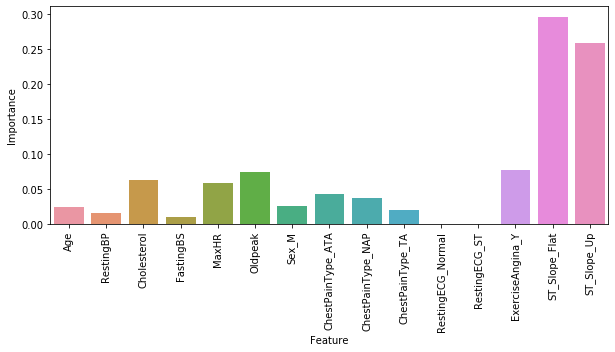

In [27]:
plt.figure(figsize=(10, 4))
sns.barplot(x = 'Feature', y = 'Importance', data=plot_df)
plt.xticks(rotation=90)

In [23]:
recall_list = []
roc_list = []
for thresh in np.arange(1, 0, -0.01):
    y_rec_p = xgb_model.predict_proba(X_test)
    y_rec_p = [1 if item[1] > thresh else 0 for item in y_rec_p]
    recall_list.append(recall_score(y_test, y_rec_p))
    roc_list.append(roc_auc_score(y_test, y_rec_p))

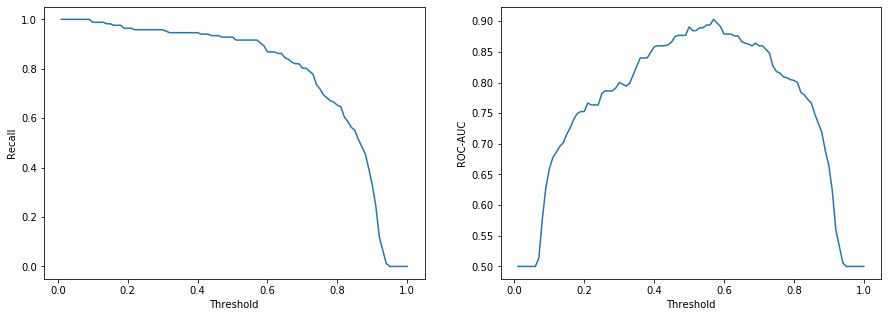

In [26]:
plot_recall = pd.DataFrame({
    'Threshold': np.arange(1, 0, -0.01),
    'Recall': recall_list,
    'ROC-AUC': roc_list
    })

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.lineplot(ax=ax1, x = 'Threshold', y = 'Recall', data = plot_recall)
sns.lineplot(ax=ax2, x = 'Threshold', y = 'ROC-AUC', data = plot_recall)
plt.subplots_adjust(hspace=1.5)

In [86]:
plot_recall.iloc[plot_recall['ROC-AUC'].idxmax()]

Threshold    0.570000
Recall       0.916168
ROC-AUC      0.903038
Name: 43, dtype: float64

In [99]:
plot_recall.iloc[60:80]

,Threshold,Recall,ROC-AUC
60,0.40,0.946108,0.858375
61,0.39,0.946108,0.849201
62,0.38,0.946108,0.840026
63,0.37,0.946108,0.840026
64,0.36,0.946108,0.840026
65,0.35,0.946108,0.826265
66,0.34,0.946108,0.812503
67,0.33,0.946108,0.798742
68,0.32,0.946108,0.794155
69,0.31,0.952096,0.797149
